# AIT Project - Final Project Undersampling

**Alan Gaugler**  
**U885853**  
**October 26, 2023**  

In the final project, I investigated if undersampling would be beneficial in addressing class imbalance. The results degraded the overall accuracy, so it was not included in the final project notebook. The work however is attached here for reference. Refer to the final project notebook for details of the final work that was carried out.

# <span style="color: darkblue;">Introduction</span>

This project is concerned with article classification. A news category dataset with over 200,000 article headlines and descriptions will be used in this project. The aim is to read and interpret the headlines and descriptions and categorize them into one of 42 topic categories. 

**Import the required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import re
import string
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
#warnings.filterwarnings('ignore')

### Exploratory Data Analysis

In [2]:
# Load the JSON file
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [3]:
# Set Pandas option to display the entire content in a column
pd.set_option('display.max_colwidth', None)

In [4]:
# Display the header
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten.""",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce.""",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.,Nina Golgowski,2022-09-22


The dataset consists of 6 columns:

**link:** The URL of the news article.<br>
**headline:** The headline of the article.<br>
**category:** The category of type or article. This is the target variable.<br>
**short_description:** A short description of the article. This will be key in identifying the article category.<br>
**authors:** The names of the article's authors.<br>
**date:** The date of the article's publication.<br>

In [5]:
df.shape

(209527, 6)

This is a large dataset with 209527 articles.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


All columns are objects except for the date which is datetime.

In [7]:
df.describe()

C:\Users\alang\AppData\Local\Temp\ipykernel_17920\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.washingtonpost.com/politics/divisions-within-gop-over-trumps-candidacy-are-growing/2016/02/28/97b16010-de3a-11e5-8d98-4b3d9215ade1_story.html,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


In [8]:
# Find the number of missing values in each column
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

There are no missing values in the dataset.

In [9]:
# Are there any duplicate headlines?
df['headline'].value_counts()

Sunday Roundup                                                                  90
The 20 Funniest Tweets From Women This Week                                     80
Weekly Roundup of eBay Vintage Clothing Finds (PHOTOS)                          59
Weekly Roundup of eBay Vintage Home Finds (PHOTOS)                              54
Watch The Top 9 YouTube Videos Of The Week                                      46
                                                                                ..
Here Are The Manufacturers Bringing The Most Jobs Back to America                1
2016 Campaigns Meet With White House To Prep For Obama's Last Days In Office     1
If Toddlers Could Calmly Articulate Their Feelings                               1
Snapchat's Bob Marley Filter Called Out For Being 'Digital Blackface'            1
Dwight Howard Rips Teammates After Magic Loss To Hornets                         1
Name: headline, Length: 207996, dtype: int64

Yes. There are many headlines that are duplicates. They all appear to be weekly articles.

In [10]:
# Are there any duplicate short descriptions?
df['short_description'].value_counts()

                                                                                                                                 19712
Welcome to the HuffPost Rise Morning Newsbrief, a short wrap-up of the news to help you start your day.                            192
The stress and strain of constantly being connected can sometimes take your life -- and your well-being -- off course. GPS         125
Want more? Be sure to check out HuffPost Style on Twitter, Facebook, Tumblr, Pinterest and Instagram at @HuffPostStyle. -- Do       91
Do you have a home story idea or tip? Email us at homesubmissions@huffingtonpost.com. (PR pitches sent to this address will         75
                                                                                                                                 ...  
The "Selma" director is teaming up with Oprah for her first ever TV series.                                                          1
It's one of the thorniest moral dilemmas in tech right 

**There are duplicate short descriptions.**

**The headline and the short description columns will be merged togther for the analysis**<br>
This will reduce the number of duplicates.

In [11]:
# Display all the categories
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [12]:
df['category'].nunique()

42

There are 42 unique values. These will be the categories.

In [13]:
# Display the number of articles per category
df['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

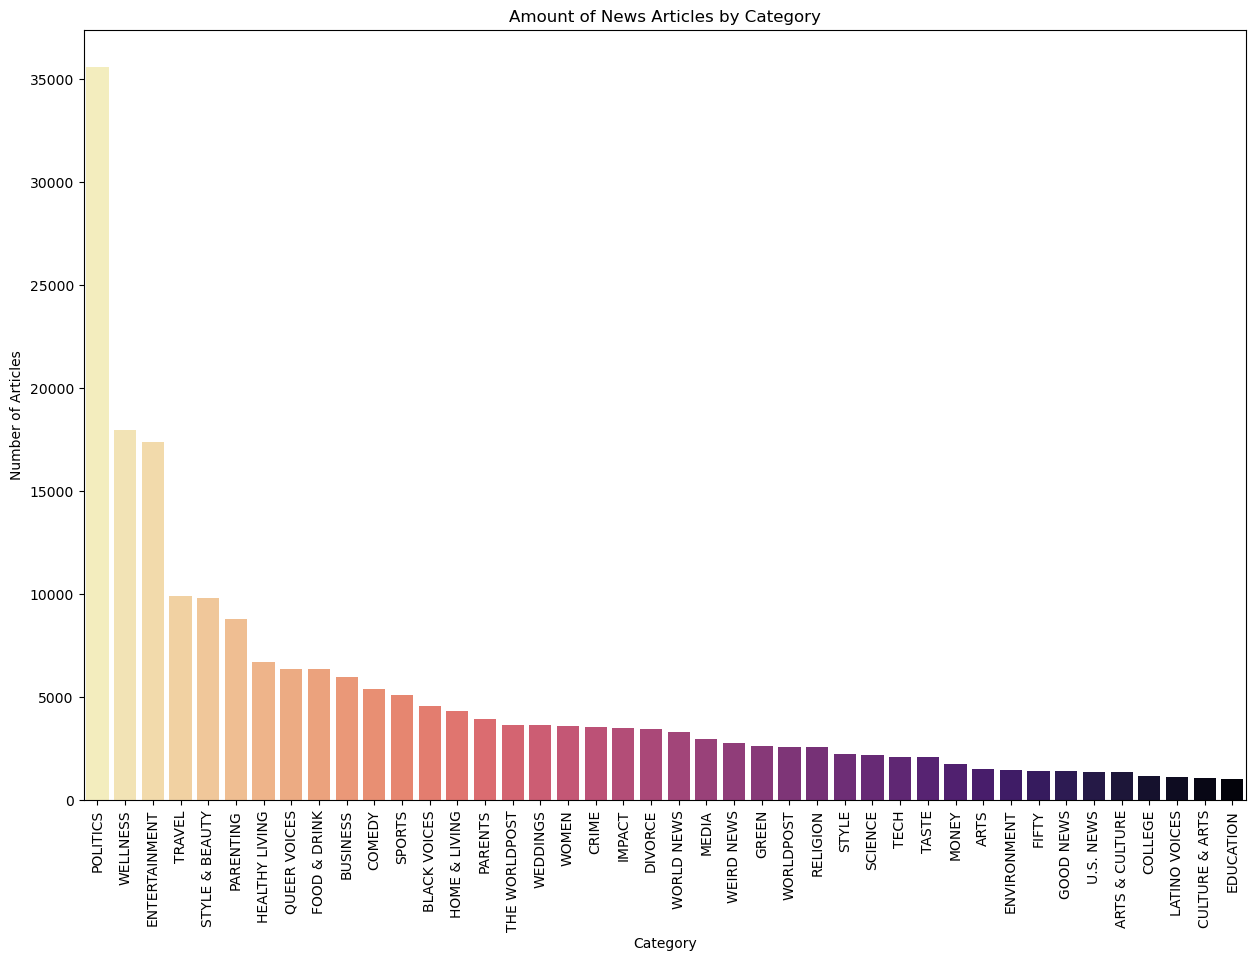

In [14]:
# Plot the distribution of news articles by news category.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['category'], order=df['category'].value_counts().index, palette="magma_r")
plt.title('Amount of News Articles by Category')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()


Politics is by far the most common category in this dataset, followed by wellness and entertainment. This dataset is clearly very imbalanced. This will produce challenges in predicting the minority categories.

In [15]:
# Add extra columns to count the number of words in the headline and the short description
df['word_count_headline'] = df['headline'].apply(lambda text: len(str(text).split()))
df['word_count_description'] = df['short_description'].apply(lambda text: len(str(text).split()))

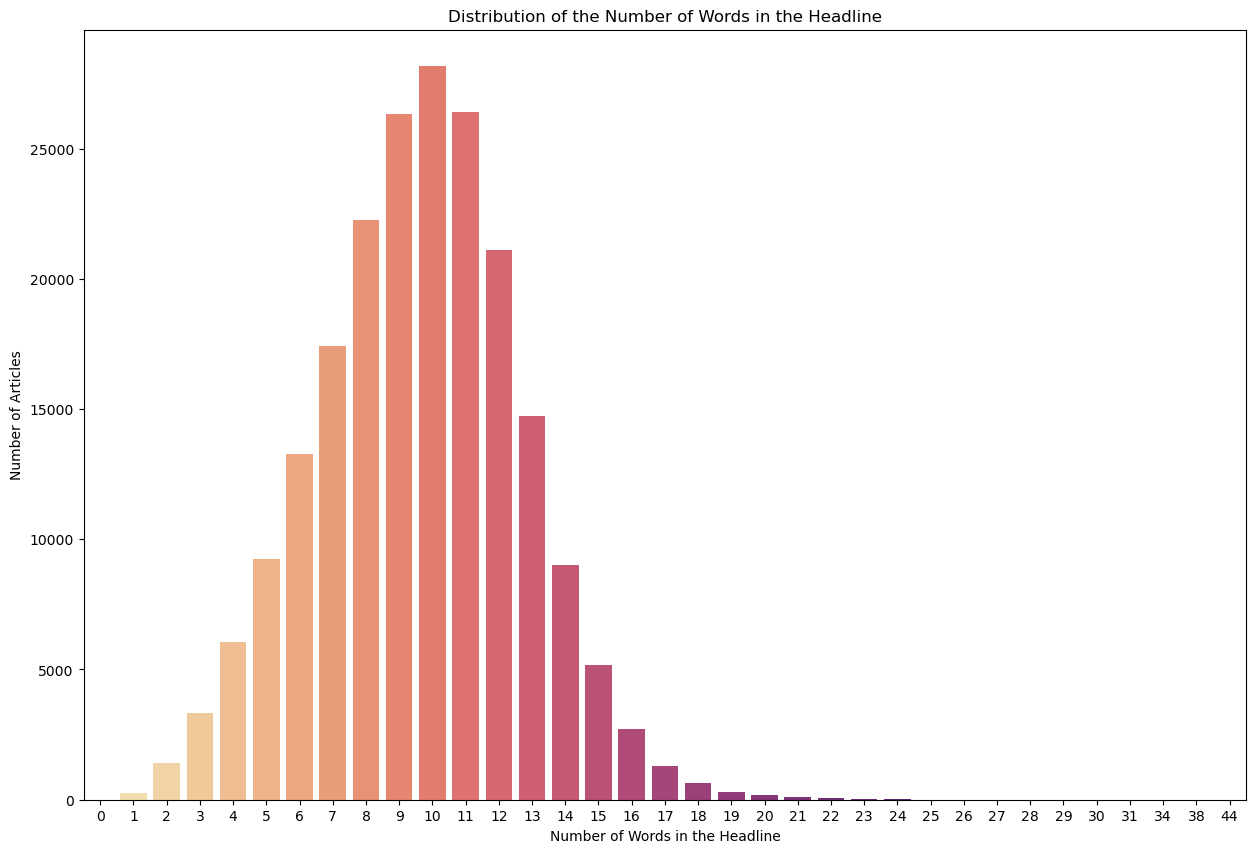

In [16]:
# Plot the Distribution of the Number of Words in the Headline.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['word_count_headline'], 
                   order=df['word_count_headline'].value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Words in the Headline')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Headline')
plt.show()

The number of words per headline has a fairly normalized distribution, centred on 10 words.

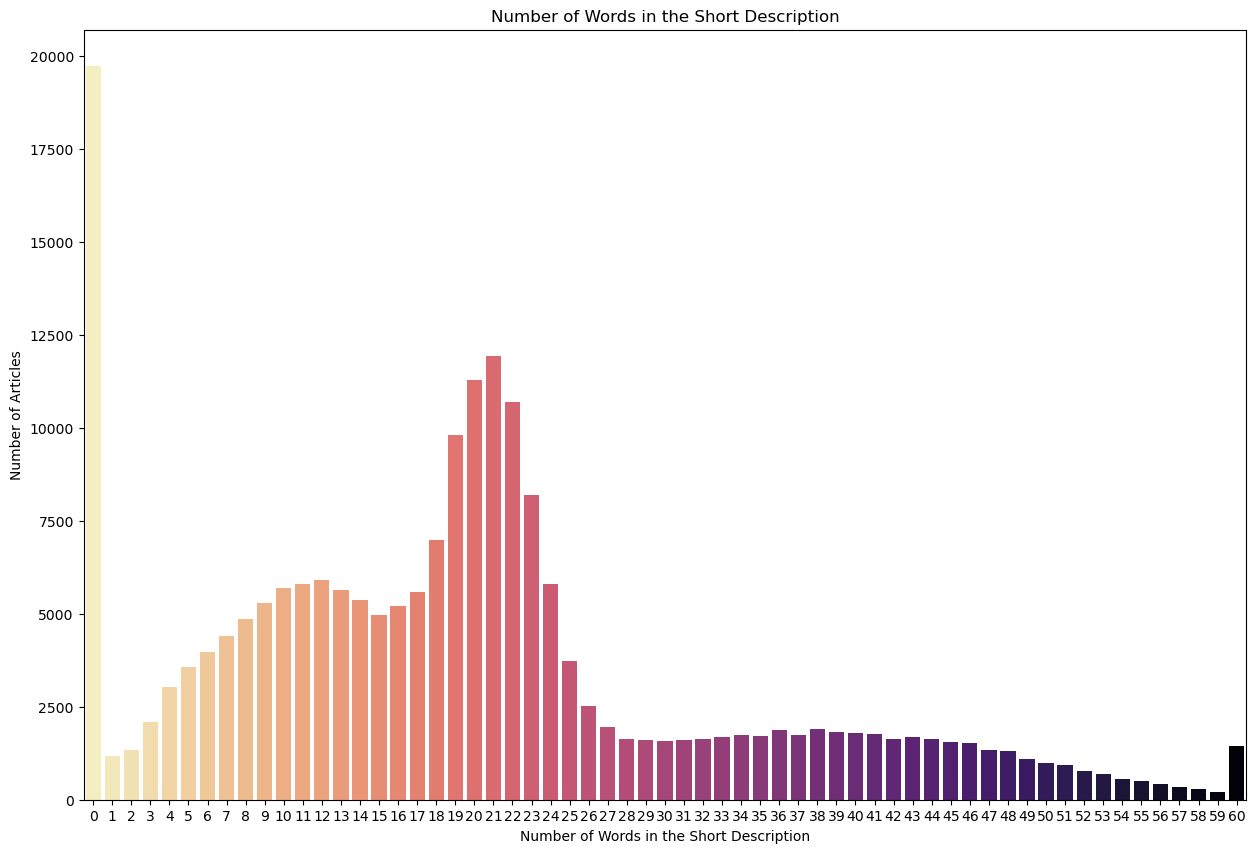

In [17]:
# Plot the Distribution of the Number of Words in the Short Description.
capped_word_count = df['word_count_description'].apply(lambda x: 60 if x >= 60 else x)

plt.figure(figsize=(15, 10))
ax = sns.countplot(x=capped_word_count, 
                   order=capped_word_count.value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Number of Words in the Short Description')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Short Description')
plt.show()

Looking at the plot above, there are 19712 articles in this dataset that do not have a description, but rather just a headline. The number 60 is actually 60+. This has been capped for this plot only but not for the actual dataset.
The distribution of the number of words in the short description interestingly has 3 peaks. The first peak is at 12 words, the largest peak is at 21 words and the smallest is at 38 words. This distribution is definitely not normal. It will be investigated to see if there is any correlation between the category and the word length of the short description.

There are 19712 articles that have no description and 6 that have no headline. To get a more complete view of the article, the headline and the short description will be merged together into a new feature called 'combined_information'.

In [18]:
# Create a new feature that concatenates 'headline' and 'short_description'.
df['combined_info'] = df['headline'].str.strip() + ' ' + df['short_description'].str.strip()

# Create an extra column to count the number of words in the combined_info feature.
df['word_count_combined'] = df['combined_info'].apply(lambda text: len(str(text).split()))

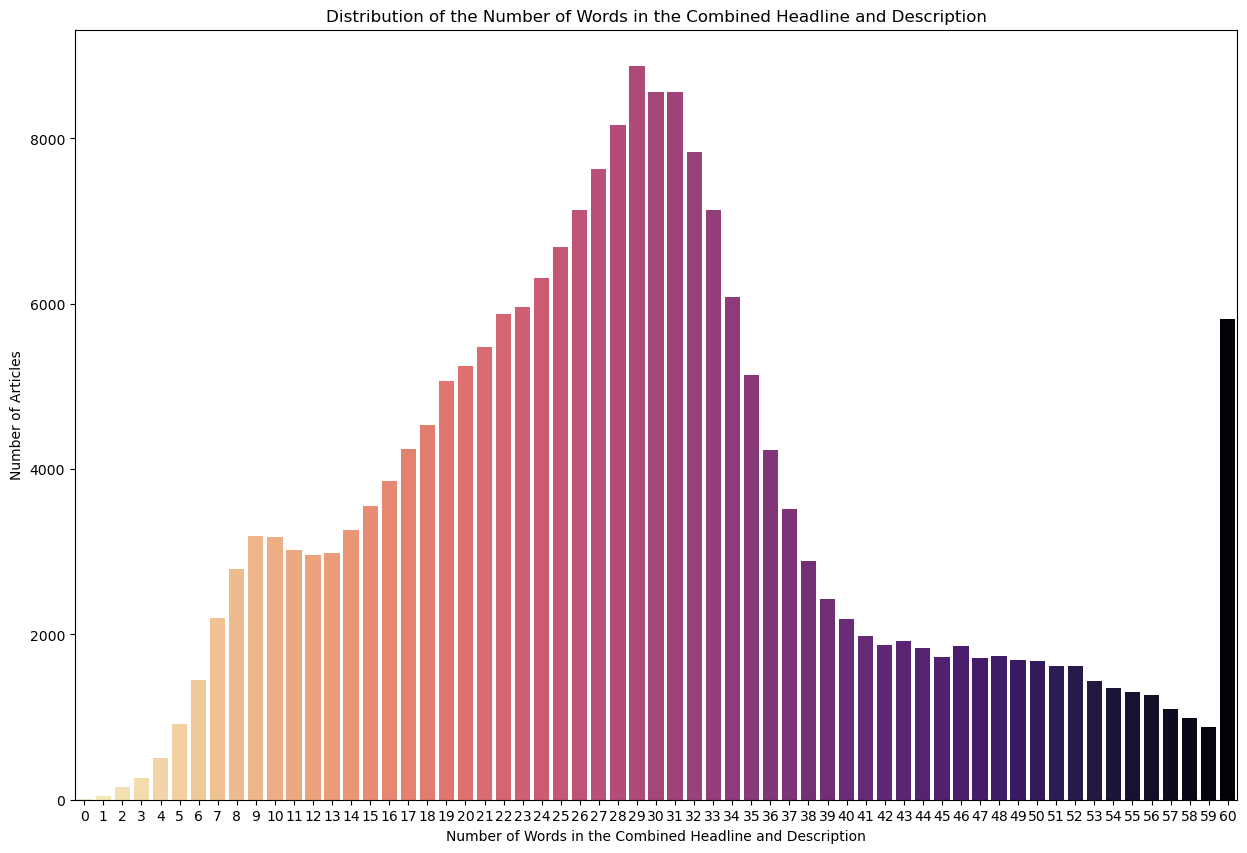

In [19]:
# Plot the Distribution of the Number of Words in the Short Description.
capped_combined_count = df['word_count_combined'].apply(lambda x: 60 if x >= 60 else x)

# Plot the Distribution of the Number of Words in the Combined Information.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=capped_combined_count, 
                   order=capped_combined_count.value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Words in the Combined Headline and Description')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Combined Headline and Description')
plt.show()

The peak of the combined word distribution is centred on 29 words. The number 60 is actually 60+. This has been capped for this plot only but not for the actual dataset.<br>

In [20]:
# Are there any duplicates in the combined info column?
df['combined_info'].value_counts()

Watch The Top 9 YouTube Videos Of The Week If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the                                         46
The Funniest Tweets From Women This Week                                                                                                                                                                     33
The 20 Funniest Tweets From Women This Week The ladies of Twitter never fail to brighten our days with their brilliant ― but succinct ― wisdom. Each week, HuffPost Women                                    30
Best Parenting Tweets: What Moms And Dads Said On Twitter This Week Kids may say the darndest things, but parents tweet about them in the funniest ways. So each week, we round up the most hilarious        26
Funniest Parenting Tweets: What Moms And Dads Said On Twitter This Week Kids may say the darndest things, but parents tweet about them in the funniest ways. So each wee

There are still duplicates in the 'combined_info' column, but this number has been reduced to just 46. 46 out of 209,527 is extremely low and will not bias the results significantly. These are articles that were actually published, so they will not be removed from this project.

In [21]:
# Create new columns for the year and month of publication.
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

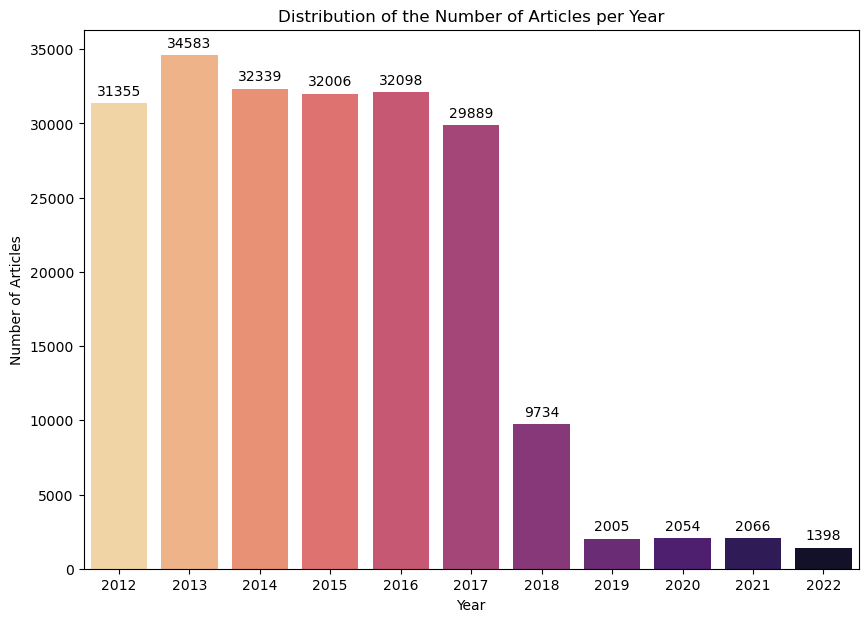

In [22]:
# Plot the Distribution of the Number of Articles per Year.
plt.figure(figsize=(10, 7))
ax = sns.countplot(x=df['year'], 
                   order=df['year'].value_counts().sort_index().index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Articles per Year')
plt.ylabel('Number of Articles')
plt.xlabel('Year')

# Add the numerical quantity at the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,  # get X coordinate + width / 2
            height + 550,  # set the text slightly above the bar
            '{:1.0f}'.format(height), 
            ha="center") 

plt.show()

The original dataset was made in June 2018, when a roughly even amount of articles were collected from 2012 to May 2018. Since then, there have been updates to the dataset but not as many new articles were collected.

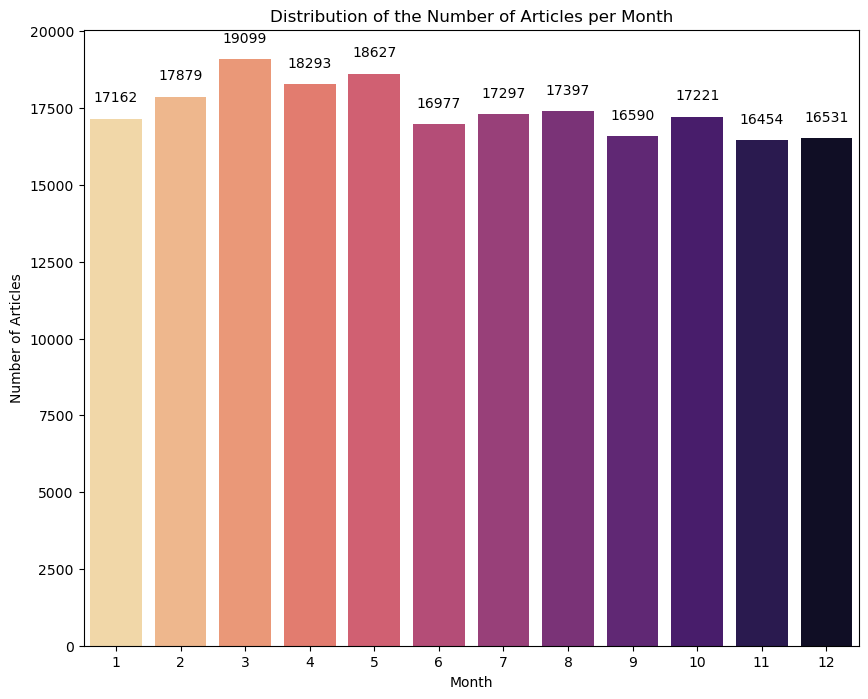

In [23]:
# Plot the Distribution of the Number of Articles per Month.
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df['month'], 
                   order=df['month'].value_counts().sort_index().index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Articles per Month')
plt.ylabel('Number of Articles')
plt.xlabel('Month')

# Add the numerical quantity at the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,  # get X coordinate + width / 2
            height + 550,  # set the text slightly above the bar
            '{:1.0f}'.format(height), 
            ha="center") 

plt.show()

The number of articles distributed per month is relatively even. The busiest month is March with 19099 and the quietest are November and December at around 16500. These months are during the holiday period in the US and more journalists may be taking time off.

In [24]:
df.describe()

,word_count_headline,word_count_description,word_count_combined,year,month
count,209527.000000,209527.000000,209527.000000,209527.000000,209527.000000
mean,9.600744,19.669026,29.269770,2014.837634,6.393100
std,3.068507,14.152783,13.803927,2.087349,3.429701
min,0.000000,0.000000,0.000000,2012.000000,1.000000
25%,8.000000,10.000000,20.000000,2013.000000,3.000000
50%,10.000000,19.000000,28.000000,2015.000000,6.000000
75%,12.000000,24.000000,35.000000,2016.000000,9.000000
max,44.000000,243.000000,245.000000,2022.000000,12.000000


In [25]:
# Observe if any 'combined_info' column is empty or contains just one word.
df[df['word_count_combined'] <= 1].head(10)

,link,headline,category,short_description,authors,date,word_count_headline,word_count_description,combined_info,word_count_combined,year,month
63714,https://www.huffingtonpost.com/entry/manscraping_b_10573084.html,"""ManScraping""",COMEDY,,"Tom Kramer, ContributorWriter of the Wry",2016-06-26,1,0,"""ManScraping""",1,2016,6
66196,https://www.huffingtonpost.com/entry/tire-d_b_10193554.html,Tire-d,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoonist",2016-05-29,1,0,Tire-d,1,2016,5
66203,https://www.huffingtonpost.com/entry/wafflewich_b_10197956.html,Wafflewich,TASTE,,"Dough Mamma, ContributorPrivate chef, culinary school graduate and second-generation f...",2016-05-29,1,0,Wafflewich,1,2016,5
72366,https://www.huffingtonpost.com/entry/hangman_b_9506810.html,Hangman,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoonist",2016-03-19,1,0,Hangman,1,2016,3
78481,https://www.huffingtonpost.com/entry/hugs_b_8950534.html,Hugs,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoonist",2016-01-10,1,0,Hugs,1,2016,1
81477,https://www.huffingtonpost.com/entry/memories_b_8730174.html,Memories,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoonist",2015-12-06,1,0,Memories,1,2015,12
81496,https://www.huffingtonpost.com/entry/what-to-do-about-disloyal_b_8734900.html,IGNORE.,POLITICS,,"Gabriela Rivera-Morales, ContributorBlog Editor, Huffington Post",2015-12-06,1,0,IGNORE.,1,2015,12
82119,https://www.huffingtonpost.com/entry/podcast_b_8674486.html,Podcast,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoonist",2015-11-29,1,0,Podcast,1,2015,11
86508,https://www.huffingtonpost.com/entry/the-idealist_b_8277718.html,Once.,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoonist",2015-10-11,1,0,Once.,1,2015,10
90944,https://www.huffingtonpost.com/entry/lincoln-20_b_8023742.html,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Brunswick Insight, and writes and speaks on...",2015-08-22,0,0,,0,2015,8


In [26]:
len(df[df['word_count_combined'] <= 1])

53

Five rows were found to not have any textual information at all in the 'combined info' column. If this column is empty, no information can be conveyed into what category it belongs to. One word is also too little information to accurately classify the topic. These rows will be removed.

In [27]:
df = df[df['word_count_combined'] > 1].copy()

In [28]:
df.shape

(209474, 12)

### <span style="color: darkblue;">Reduce the Number of News Categories</span>

It was observed that many of the article categories are very similar. This will now be investigated further with the aim of merging two or more topics that are similar. 

In [29]:
# Display all the categories
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

Observing above, there are 42 categories. There are many examples of where two or more categories are very similar and could even be considered the same. To make the classification task more realistic, some of these categories can be merged together. After careful consideration, it is been decided to merge the following categories:  

In [30]:
# Make a new feature called 'category_red' (reduced)
df['category_red'] = df['category']

In [31]:
# Relabel one category to another related category
df['category_red']=df['category_red'].replace({'PARENTS': 'PARENTING',
                                       'THE WORLDPOST': 'WORLD NEWS',
                                       'WORLDPOST': 'WORLD NEWS',
                                       'BUSINESS': 'BUSINESS & FINANCE',
                                       'MONEY': 'BUSINESS & FINANCE',
                                       'COLLEGE': 'EDUCATION',
                                       'STYLE': 'STYLE & BEAUTY',
                                       'GREEN': 'ENVIRONMENT',
                                       'ARTS': 'ARTS & CULTURE',
                                       'CULTURE & ARTS': 'ARTS & CULTURE',
                                       'HEALTHY LIVING': 'WELLNESS',
                                       'TASTE': 'FOOD & DRINK'})

It may have been possible to further reduce the number of articles, by combining the 'BLACK VOICES', 'QUEER VOICES' and 'LATINO VOICES' categories together and also maybe 'SCIENCE' and 'TECH' and possibly more, but I consider those to be too distinct from each other. The choices of categories I made above I believe are similar enough to be merged together.

In [32]:
 #Left out for now                                     
                                       


df['category']=df['category'].replace({
"QUEER VOICES": "GROUPS VOICES",

"BLACK VOICES": "GROUPS VOICES",



"SCIENCE": "SCIENCE & TECH",
"TECH": "SCIENCE & TECH",

"LATINO VOICES": "GROUPS VOICES",

"FIFTY": "MISCELLANEOUS",
"GOOD NEWS": "MISCELLANEOUS"})

In [33]:
filtered_df = df[df['category'] == 'TASTE']
filtered_df.head()

,link,headline,category,short_description,authors,date,word_count_headline,word_count_description,combined_info,word_count_combined,year,month,category_red
16173,https://www.huffingtonpost.com/entry/ice-water-restaurants-american_us_5a5683bce4b08a1f624b0f17,It's Weird That American Restaurants Serve Ice Water In Winter,TASTE,But why do we even have ice in our drinks in the first place?,Todd Van Luling,2018-01-16,10,14,It's Weird That American Restaurants Serve Ice Water In Winter But why do we even have ice in our drinks in the first place?,24,2018,1,FOOD & DRINK
16242,https://www.huffingtonpost.com/entry/pineapple-casserole-recipe_us_5a562ef6e4b0d614e48b9b98,"Pineapple Casserole, The Southern Dish That's A Paradox Of Flavors",TASTE,"It's got pineapple, cheddar and a whole lot of butter.",Kristen Aiken,2018-01-16,10,10,"Pineapple Casserole, The Southern Dish That's A Paradox Of Flavors It's got pineapple, cheddar and a whole lot of butter.",20,2018,1,FOOD & DRINK
16516,https://www.huffingtonpost.com/entry/how-to-get-a-bartenders-attention_us_5a55372ce4b0b117f88041e3,How To Actually Get A Bartender's Attention,TASTE,Plus other things they wish you knew.,Taylor Pittman,2018-01-11,7,7,How To Actually Get A Bartender's Attention Plus other things they wish you knew.,14,2018,1,FOOD & DRINK
16599,https://www.huffingtonpost.com/entry/diet-coke-makeover-twitter_us_5a5676a9e4b08a1f624afc32,Diet Coke's Millennial-Inspired Makeover Leaves People Befuddled,TASTE,"It's not like a regular soda, it's a cool soda.",Abigail Williams,2018-01-10,7,10,"Diet Coke's Millennial-Inspired Makeover Leaves People Befuddled It's not like a regular soda, it's a cool soda.",17,2018,1,FOOD & DRINK
16776,https://www.huffingtonpost.com/entry/sunions-tearless-onions_us_5a4fa3c2e4b003133ec776d5,We Tested The New 'Tearless' Onions To See If They Really Work,TASTE,"Put away your goggles, people.",Kristen Aiken,2018-01-08,12,5,"We Tested The New 'Tearless' Onions To See If They Really Work Put away your goggles, people.",17,2018,1,FOOD & DRINK


In [34]:
# Display the number of reduced categories
df['category_red'].nunique()

31

The number of categories has now been reduced from 42 to 31. This is a reduction of 11 categories.

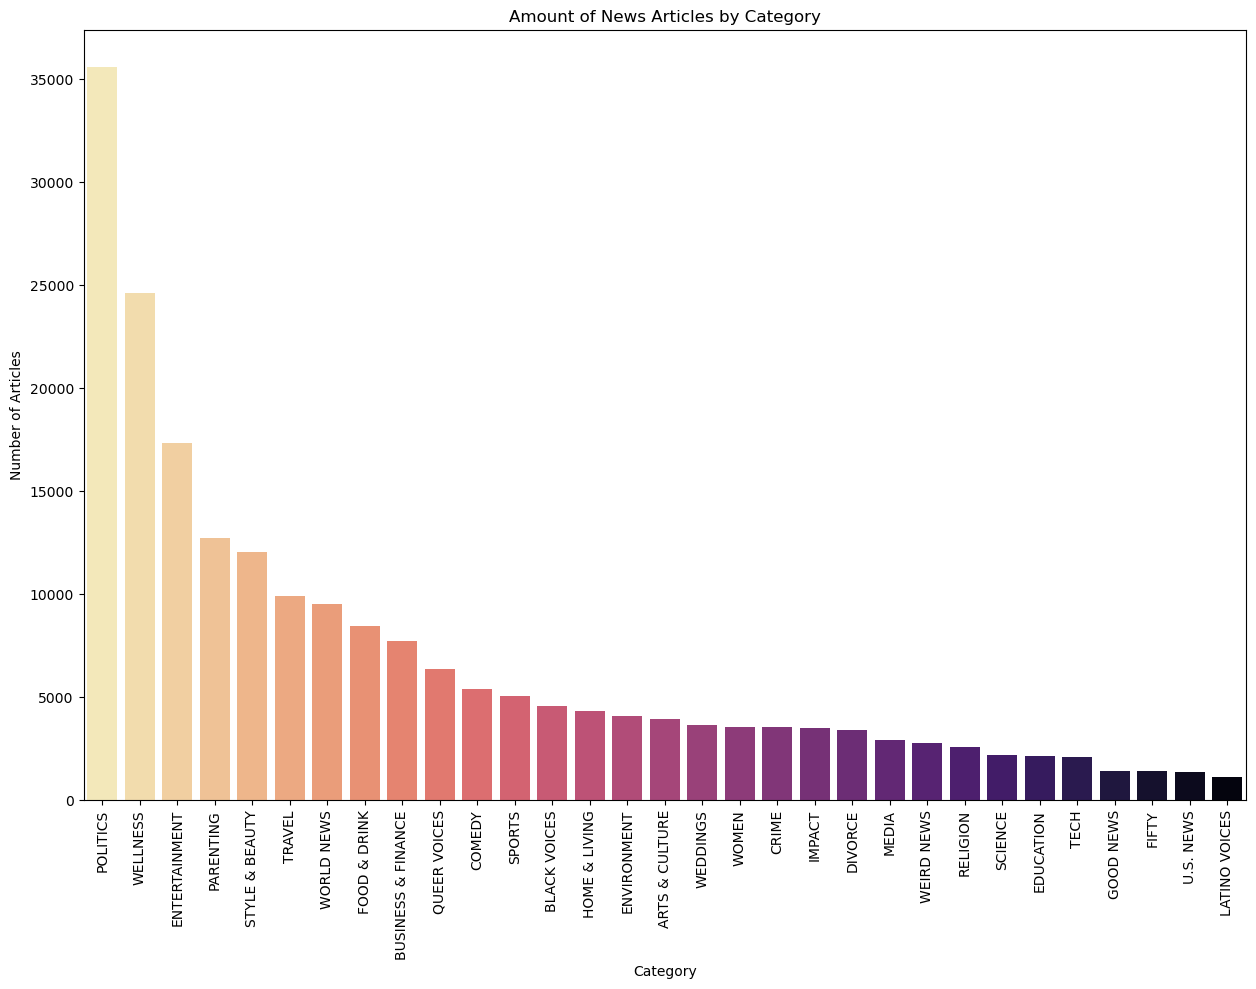

In [35]:
# Plot the distribution of news articles by news category.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['category_red'], order=df['category_red'].value_counts().index, palette="magma_r")
plt.title('Amount of News Articles by Category')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

There is still a large imbalance between the majority and the minority classes, which will still be a challenge. This will be investigated.

**Display the number of articles per category**

In [36]:
# Display the number of articles per category
category_counts = df['category_red'].value_counts()
category_counts

POLITICS              35598
WELLNESS              24633
ENTERTAINMENT         17360
PARENTING             12746
STYLE & BEAUTY        12068
TRAVEL                 9897
WORLD NEWS             9540
FOOD & DRINK           8435
BUSINESS & FINANCE     7745
QUEER VOICES           6346
COMEDY                 5384
SPORTS                 5075
BLACK VOICES           4583
HOME & LIVING          4320
ENVIRONMENT            4066
ARTS & CULTURE         3922
WEDDINGS               3653
WOMEN                  3570
CRIME                  3562
IMPACT                 3483
DIVORCE                3426
MEDIA                  2943
WEIRD NEWS             2776
RELIGION               2576
SCIENCE                2206
EDUCATION              2157
TECH                   2104
GOOD NEWS              1397
FIFTY                  1396
U.S. NEWS              1377
LATINO VOICES          1130
Name: category_red, dtype: int64

### Undersampling of Majority Classes

To reduce training time for this large dataset and to address the large class imbalance among the 31 classes, undersampling will be performed. I will reduce the dataset to approximately 50,000 news article samples, which is approximately 24% of the original dataset size. This means that the maximum number of samples per class is 1656.

In [37]:
# Import the required library
from sklearn.utils import resample

In [38]:
# Define a threshold for the maximum number of articles per category.
max_articles_per_category = 1656

In [39]:
# Obtain a list of categories that will be reduced
categories_to_reduce = category_counts[category_counts > max_articles_per_category].index

In [40]:
categories_to_reduce

Index(['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'PARENTING', 'STYLE & BEAUTY',
       'TRAVEL', 'WORLD NEWS', 'FOOD & DRINK', 'BUSINESS & FINANCE',
       'QUEER VOICES', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING',
       'ENVIRONMENT', 'ARTS & CULTURE', 'WEDDINGS', 'WOMEN', 'CRIME', 'IMPACT',
       'DIVORCE', 'MEDIA', 'WEIRD NEWS', 'RELIGION', 'SCIENCE', 'EDUCATION',
       'TECH'],
      dtype='object')

In [41]:
len(categories_to_reduce)

27

In [42]:
# Make a copy of the dataframe
df_red = df.copy()

**Downsize the larger categories**

In [43]:
for category in categories_to_reduce:
    # Get the original number of samples for this class
    original_count = category_counts[category]
    
    # Determine the number of samples to remove. This must not be more than the original count
    num_articles_to_remove = original_count - max_articles_per_category
    
    # Randomly select articles to remove
    indices_to_remove = resample(
        df_red[df_red['category_red'] == category].index, 
        replace=False, 
        n_samples=num_articles_to_remove, 
        random_state=12  # Set a seed for consistency
    )
    
    # Drop these indices from the dataframe
    df_red = df_red.drop(indices_to_remove)

In [44]:
df_red['category_red'].value_counts()

BUSINESS & FINANCE    1656
COMEDY                1656
WEDDINGS              1656
IMPACT                1656
RELIGION              1656
TRAVEL                1656
QUEER VOICES          1656
WELLNESS              1656
WOMEN                 1656
HOME & LIVING         1656
BLACK VOICES          1656
MEDIA                 1656
STYLE & BEAUTY        1656
WORLD NEWS            1656
DIVORCE               1656
FOOD & DRINK          1656
CRIME                 1656
PARENTING             1656
SCIENCE               1656
EDUCATION             1656
ENTERTAINMENT         1656
WEIRD NEWS            1656
ENVIRONMENT           1656
SPORTS                1656
POLITICS              1656
ARTS & CULTURE        1656
TECH                  1656
GOOD NEWS             1397
FIFTY                 1396
U.S. NEWS             1377
LATINO VOICES         1130
Name: category_red, dtype: int64

In [45]:
# Reset the indices after dataframe reduction
df_red.reset_index(drop=True, inplace=True)

The 31 classes have now been balanced very well, class imbalance is no longer an issue. The baseline models will be run to evaluate the performance.

## Feature Engineering / Data Preparation

### <span style="color: darkblue;">Text Cleaning and Preprocessing</span>

To prepare the data for natural language processing (NLP), several steps will need to be taken:<br>

1. Text Cleaning - The preprocessing step will convert the text to lowercase, strip and remove punctuations, effectively cleaning the text for further processing. 
2. Expand contractions - Contracted words are converted into two words which make more sense. Also, the apostrophes will be removed. An example of this is: "I'd" --> "I would". Many of these words will be removed by the stop word removal step.  
3. Tokenization - Partition the text into individual words and symbols. These are called tokens.
4. Stop word removal - This will remove common words that convey no meaning about the article such as "he", "she" or "on".
5. Stemming - This reduces words to their root form i.e., "shows", "showing" and "showed" will be reduced to "show".
6. Lemmatization - This also reduces words to their root form i.e., "better" and "best" will be reduced to "good". This is similar to stemming but the root words are more often real words used in English rather than just their stems.  
7. Bigrams and trigrams - Many words often connected in sequence may have a different meaning and should be joined together such as "New" followed by "York" really conveys the meaning of a city called "New York" and they should be considered one word.
8. Removal of unique words - Unique words or words that occur only one time in the entire dataset will be removed. As these words are unique, they will not be encountered in the test set if they are in the training set and so will not convey any information in identifying the topic category. This will also reduce the “noise” in the dataset and speed up processing.
  

The Natural Language Toolkit (NLTK) and Gensim libraries will be used for this project.

In [46]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import gensim
from gensim.models import Word2Vec

In [48]:
# Install the necessary NLTK datasets if they are not in the environment yet.
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [49]:
# Define the English language stopwords.
stop_words = set(stopwords.words('english'))

# Load the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [50]:
# Display the English stopwords in the NLTK library
print(stop_words)

{'too', 'itself', 'when', 'ma', 'our', 'themselves', 'ain', 'out', 'am', 'through', "should've", 'them', "mustn't", 'do', 'did', 'don', 'all', "shouldn't", 'been', 'her', 'a', 'can', 'while', 'he', 'what', 'mustn', 'shan', 'there', 'wouldn', 'into', 'why', 'but', "you've", 'who', 'under', 'here', 'as', 'than', 'down', 'with', 'no', "couldn't", 'ourselves', 'or', "needn't", 'herself', 'theirs', 'isn', 'once', 'shouldn', "wouldn't", 'is', 'very', 'then', 'and', 'yourself', 'off', "you're", 'most', 'weren', 'was', 'will', 'such', 'in', 'just', "it's", "didn't", 'll', "you'll", 'my', 'i', 'again', 'his', "she's", 'same', 'their', 'being', 'an', 'does', 'didn', 'for', 'having', "you'd", 'other', 'to', 'whom', 'myself', 'hadn', 'doesn', 'its', 'won', 'between', 'couldn', 'those', "doesn't", 'not', 'which', 'by', 'each', 'mightn', "wasn't", 'both', 'hers', 'above', 't', 'she', 'they', 've', 'now', 'we', 'were', 'these', 'at', 'nor', 'be', 'himself', 'until', 'so', 'me', 'after', "aren't", "ha

In [51]:
len(stop_words)

179

NLTK's English stopwords library contains 179 words.

In [52]:
df.dtypes

link                              object
headline                          object
category                          object
short_description                 object
authors                           object
date                      datetime64[ns]
word_count_headline                int64
word_count_description             int64
combined_info                     object
word_count_combined                int64
year                               int64
month                              int64
category_red                      object
dtype: object

In [53]:
# Make a contractions map:
# A contraction map will convert contracted words into two words
# which make more sense. Also, the apostrophes will be removed.
# Credit: This contraction map was obtained from the following source:
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


In [54]:
# Credit: This function to expand contractions was obtained from the following source:
# https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [55]:
# Credit: The processing text function shown below is based on code found at the following source:
# Reference: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
# The preprocessing step will convert the text to lowercase, strip and remove punctuations
# effectively cleaning the text for further processing.

def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    # Call the expand contractions function
    # It was found that this led to a minore decrease in model performance so it has been commented out.
    #text = expand_contractions(text)
    # Remove any leading or trailing whitespace.
    text = text.strip()
    # Remove any HTML tags from the text
    text = re.compile('<.*?>').sub('', text)
    # Replace any punctuation with a space
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    # Remove any square-bracketed numbers (like [10], [23], etc.)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    # Remove any non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [56]:
# This is a modification from the preprocess_text function for preparation of DistilBERT.
# The difference is that the replacing the punctuation with a space step has been removed. 
# DistilBERT considers punctuation in the sentence's context, so the punctuation marks remain.

def preprocess_text_bert(text):
    # Convert the text to lowercase
    text = text.lower()
    # Call the expand contractions function
    ### It was found that this led to a minore decrease in model performance so it has been commented out.
    text = expand_contractions(text)
    # Remove any leading or trailing whitespace.
    text = text.strip()
    # Remove any HTML tags from the text
    text = re.compile('<.*?>').sub('', text)
    # Remove any square-bracketed numbers (like [10], [23], etc.)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    # Remove any non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [57]:
# Create a wordcloud for the desired column
def plot_word_cloud(lemmatized_words, col_name):
    # Combine all the words into one list instead of a list of lists
    word_list = [word for sublist in lemmatized_words for word in sublist]

    # Combine all the words into one large text
    text = ' '.join(word_list)

    # Create the word cloud object
    wc = WordCloud(width=800, height=800, colormap='Spectral', background_color='black', 
                   stopwords=set('english'), max_words=200, contour_color='black')

    # Generate the word cloud
    wc.generate(text)

    # Display the word cloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {col_name}')
    plt.show()

In [58]:
def process_column(df_red, column_name):
    # 1. Text Cleaning
    clean_text = df_red[column_name].apply(lambda x: preprocess_text(x))
    
    # 2. Tokenization - Tokenize the articles into words and punctuation.
    tokenized_text = clean_text.apply(word_tokenize)
    
    # 3. Removal of Stop Words
    stop_words = set(stopwords.words('english'))
    stop_words_removed = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
    
    # Bigrams and trigams reduced the classification accuracy so it has been disabled.
    """
    # 4. Add Bi-grams
    # Convert the stop words removed tokenized data into a list of lists format for bigram model training
    bigrams_input = stop_words_removed.tolist()   
    # Create a bigram phraser. The bigram phrase must appear at least 5 times to be considered.
    bigram = Phrases(bigrams_input, min_count=200, threshold=200)
    bigram_phraser = Phraser(bigram)   
    # Apply the bigram phraser on the tokenized data
    bigram_output = [bigram_phraser[doc] for doc in bigrams_input]
       
    unique_bigrams = set()
    for doc in bigram_output[:2000]:
        for token in doc:
            if "_" in token:  # bigrams are represented with underscores
                unique_bigrams.add(token)
    
    print(f'Number of bigrams: {len(unique_bigrams)}')
    print(unique_bigrams)
    
    # Add Tri-grams - This is effectively the same process as bigrams, where a third word may be added to a bigram word
    # if the sequence occurs sufficiently
    trigram = Phrases(bigram_output, min_count=5, threshold=30)
    trigram_phraser = Phraser(trigram)
    trigram_output = [trigram_phraser[bigram_phraser[doc]] for doc in bigrams_input] 
    """
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = stop_words_removed.apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Stemming was more accurate than lemmatization for the best model performance.
    # 4. Perform lemmatization on all words.
    #lemmatizer = WordNetLemmatizer()
    #lemmatized_words = list(map(lambda doc: [lemmatizer.lemmatize(word) for word in doc], stop_words_removed))
    
    # Convert lemmatized/stemmed words back to string format and add to the dataframe
    processed_column_name = 'processed_' + column_name
    df_red[processed_column_name] = [' '.join(words) for words in stemmed_words]

    return df_red, stemmed_words

In [59]:
# Select the Headline column to process
#df_red, lemmatized_words = process_column(df_red, 'headline')

In [60]:
# Plot a word cloud for the Headlines
#plot_word_cloud(lemmatized_words, 'Headlines')

In [61]:
# Process the 'short description' column and plot the word cloud
#df_red, lemmatized_words = process_column(df_red, 'short_description')

In [62]:
#plot_word_cloud(lemmatized_words, 'short_description')

In [63]:
# Process the 'combined info' column and plot the word cloud
df_red, lemmatized_words = process_column(df_red, 'combined_info')

In [64]:
#plot_word_cloud(lemmatized_words, 'combined_info')

In [65]:
df_red['combined_info'][100]

'U.S. Unemployment Claims Rise To Highest Level Since November Applications for jobless aid climbed by 14,000 to 262,000 and now have risen five out of the last six weeks, the Labor Department reported.'

In [66]:
df_red['processed_combined_info'][100]

'u unemploy claim rise highest level sinc novemb applic jobless aid climb 14 000 262 000 risen five last six week labor depart report'

**Split the data into training and test sets**

In [67]:
df_red.head()

,link,headline,category,short_description,authors,date,word_count_headline,word_count_description,combined_info,word_count_combined,year,month,category_red,processed_combined_info
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23,11,29,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,40,2022,9,U.S. NEWS,4 million american roll sleev omicron target covid booster health expert said earli predict whether demand would match 171 million dose new booster u order fall
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23,13,28,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",41,2022,9,U.S. NEWS,american airlin flyer charg ban life punch flight attend video subdu passeng crew fled back aircraft confront accord u attorney offic lo angel
2,https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.,Nina Golgowski,2022-09-22,11,25,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.,36,2022,9,U.S. NEWS,woman call cop black bird watcher lose lawsuit ex employ ami cooper accus invest firm franklin templeton unfairli fire brand racist video central park encount went viral
3,https://www.huffpost.com/entry/belk-worker-found-dead-columbiana-centre-bathroom_n_632c5f8ce4b0572027b0251d,Cleaner Was Dead In Belk Bathroom For 4 Days Before Body Found: Police,U.S. NEWS,"The 63-year-old woman was seen working at the South Carolina store on Thursday. She was found dead Monday after her family reported her missing, authorities said.",,2022-09-22,13,26,"Cleaner Was Dead In Belk Bathroom For 4 Days Before Body Found: Police The 63-year-old woman was seen working at the South Carolina store on Thursday. She was found dead Monday after her family reported her missing, authorities said.",39,2022,9,U.S. NEWS,cleaner dead belk bathroom 4 day bodi found polic 63 year old woman seen work south carolina store thursday found dead monday famili report miss author said
4,https://www.huffpost.com/entry/reporter-gets-adorable-surprise-from-her-boyfriend-while-working-live-on-tv_n_632ccf43e4b0572027b10d74,Reporter Gets Adorable Surprise From Her Boyfriend While Live On TV,U.S. NEWS,"""Who's that behind you?"" an anchor for New York’s PIX11 asked journalist Michelle Ross as she finished up an interview.",Elyse Wanshel,2022-09-22,11,20,"Reporter Gets Adorable Surprise From Her Boyfriend While Live On TV ""Who's that behind you?"" an anchor for New York’s PIX11 asked journalist Michelle Ross as she finished up an interview.",31,2022,9,U.S. NEWS,rep

**Removal of the unique words from "processed_combined_info"**  
Unique words that appear only once in the entire corpus will not be very useful for classification of categories. These words will be removed.

In [68]:
def remove_unique_words(df_red, column):
    # Extract all the words from all the speeches in the 'Processed_Text' column
    split_words = df_red[column].str.split().tolist()
    # Flatten the list of lists and count the frequency of each word
    word_frequency = Counter(word for row in split_words for word in row)
    print(f'word count: {len(word_frequency)}')
    # Obtain a set of all the words appearing only once (unique words)
    unique_words = set()
    for word, count in word_frequency.items():
        if count == 1:
            unique_words.add(word)
    print(f'num unique words: {len(unique_words)}')   
    
    # Remove the unique words from all articles of the specified column
    col_without_unique = []
    for row in split_words:
        row_without_unique = []
        # Search through all words in each row and only keep the words that are not in the unique word set
        for word in row:
            if word not in unique_words:
                row_without_unique.append(word)
        # Join the word lists into a string and append to the column series.
        col_without_unique.append(" ".join(row_without_unique))
        
    # Apply the column series to the specified column
    df_red[column] = col_without_unique
    return df_red


In [69]:
df_red = remove_unique_words(df_red, 'processed_combined_info')

word count: 34507
num unique words: 13685


There are 62,896 different words in the entire corpus. 25,711 words appear only once. They were removed from the corpus.

**Split the data into training and test sets**

In [70]:
# 1. Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(df_red["processed_combined_info"],df_red["category_red"],test_size=0.2,
                                    stratify=df_red["category_red"], random_state=12, shuffle=True)

### Text Vectorization

Machine learning models require numerical input rather than textual, so text needs to be converted into vectors. Converting text into numerical data is called 'vectorization' or 'embedding'.<br>

**Bag of words** is a basic method that converts text to vectors. Each word in the corpus is given an index and the word's frequency is associated with it. There are no more complex structures for this method.<br>

It was observed that bag of words did not perform as well as tf-idf for the baseline. It will be evaluated again on the more complex models.

**Term Frequency-Inverse Document Frequencies (Tf-Idf)**  
is a more advanced method. Instead of just counting the number of words, tf-Idf  also adjusts word values based on their occurrence frequency in all the headline rows, reducing the weight to the more commonly occurring terms.

In [71]:
# 2. Vectorization - Method 1 - This limits the number of features to the top max_features most frequent terms
vectorizer = TfidfVectorizer(max_features=50000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [72]:
# The model was the highest accuracy deployed the previous method of Tf-idf vectorization
"""
# 2. Vectorization - Method 2
# Exclude the words that appear in more than 95% of the combined_info entries and
# Include only words that appear in 2 or more documents.

# Set up the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the training data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vec = tfidf_vectorizer.transform(X_test)
"""

"\n# 2. Vectorization - Method 2\n# Exclude the words that appear in more than 95% of the combined_info entries and\n# Include only words that appear in 2 or more documents.\n\n# Set up the TfidfVectorizer\ntfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')\n\n# Fit and transform the training data\nX_train_vec = tfidf_vectorizer.fit_transform(X_train)\n\n# Transform the test data\nX_test_vec = tfidf_vectorizer.transform(X_test)\n"

This method was observed to work best for all the text vectorization methods tested, unless a high value of max_features was used in Method 1.

**Word2vec**  
This is a more advanced neural network-based algorithm that learns word associations from a large corpus of text. Word2vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors. Credit: Analytics Vidhya.


It was observed that Word2vec did not perform as well as tf-idf for the baseline models. It will be evaluated again on the more complex models.

## Machine Learning  

Two models have been used as a baseline for testing the dataset. A Multinomial Naive-Bayes model and a Logistic Regression model. These are two basic models. The purpose of this section for the mid-semester report is to demonstrate that a baseline model can be used to produce an output on the chosen dataset. The models have been left with their default hyperparameter settings and were not tuned. For the final report, more advanced models will be evaluated and tuned to obtain maximum performance. 

In the baseline, various text processing and vectorization steps were configured to determine which steps work best for this dataset. Please refer to the midsemester report for the evaluation of the preprocessing steps. The configuration shown here is for the best combination of all the preprocessing steps that were evaluated.

Note that the best result was achieved on the logistic regression model.

#### Multinomial Naive-Bayes Model

In [73]:
# 3. Train the Naive-Bayes model
nb1 = MultinomialNB()
nb1.fit(X_train_vec, y_train)

MultinomialNB()

In [74]:
# 4. Evaluate the model
y_pred_nb1 = nb1.predict(X_test_vec)

In [75]:
# Display the model's classification accuracy
accuracy_nb1 = accuracy_score(y_test, y_pred_nb1)
print(f"Accuracy: {accuracy_nb1 * 100:.2f}%")

# Classification Report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb1, labels=sorted_labels))

Accuracy: 55.21%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.56      0.44      0.49       331
      BLACK VOICES       0.56      0.40      0.47       331
BUSINESS & FINANCE       0.49      0.46      0.48       332
            COMEDY       0.58      0.47      0.52       332
             CRIME       0.45      0.73      0.55       331
           DIVORCE       0.61      0.84      0.71       331
         EDUCATION       0.57      0.69      0.62       332
     ENTERTAINMENT       0.46      0.37      0.41       331
       ENVIRONMENT       0.53      0.52      0.53       331
             FIFTY       0.61      0.30      0.40       279
      FOOD & DRINK       0.69      0.79      0.74       331
         GOOD NEWS       0.60      0.30      0.40       280
     HOME & LIVING       0.65      0.75      0.69       331
            IMPACT       0.36      0.47      0.41       332
     LATINO VOICES       0.86      0.21      0.34       2

For the Naive-Bayes model, with the addition of undersampling, there are no longer any classes that were never predicted. the overall accuracy has improved from 50.67% to 55.21% 

**Confusion Matrix**

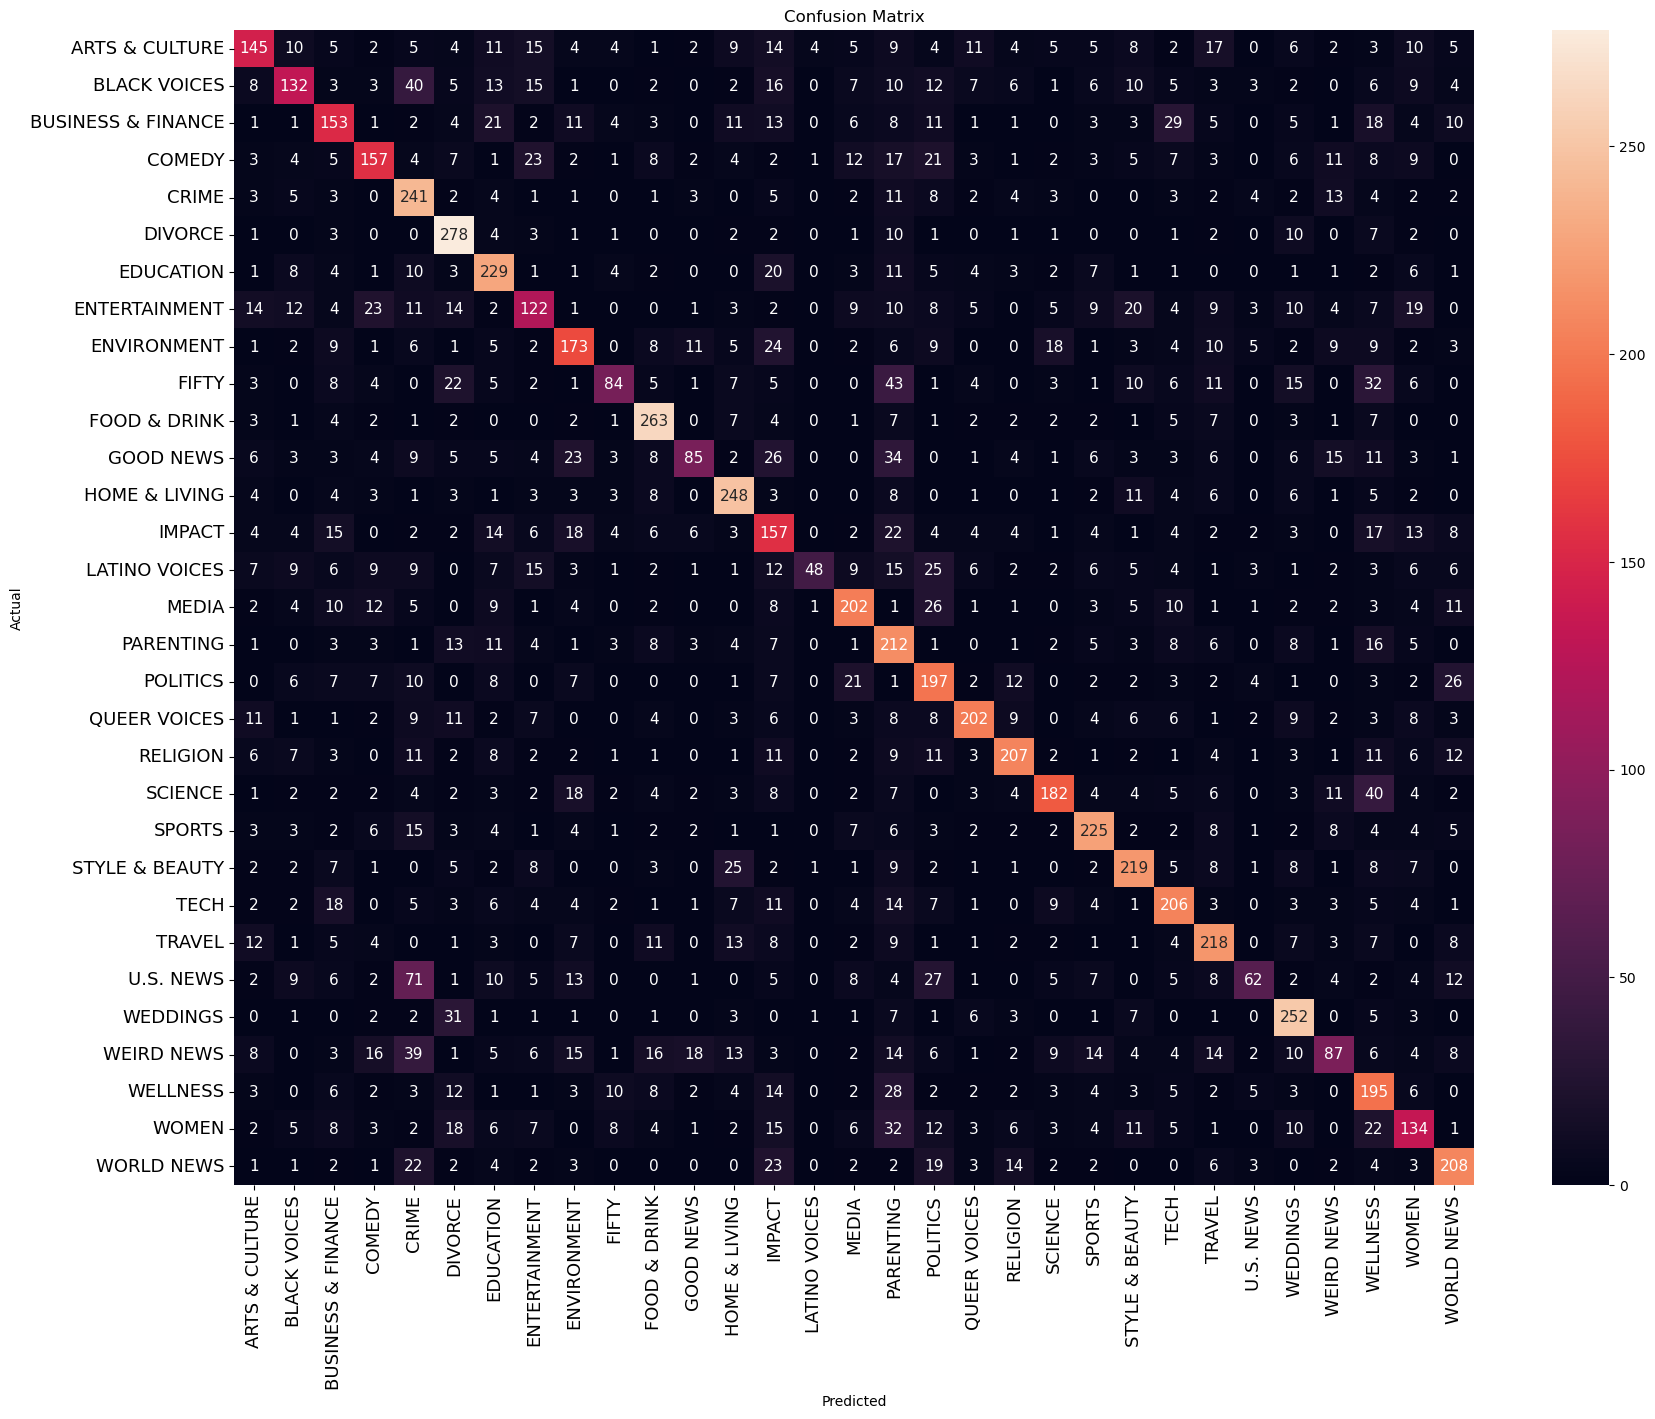

In [76]:
# Generate the confusion matrix
conf_matrix_nb1 = confusion_matrix(y_test, y_pred_nb1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix_nb1, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)  
plt.yticks(fontsize=13)  
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Summary of the Naive-Bayes Model**  

For the Naive-Bayes model, with the addition of undersampling, there are no longer any classes that were never predicted. the overall accuracy has improved from 50.67% to 55.21%. 

Precision has fallen from 0.68 to 0.57, however there has been a large improvement in recall from 0.22 to 0.54. The F1-score has also improved from 0.23 to 0.54.

The real test is on the logistic regression model as it performed better on the baseline.

#### Logistic Regression Model

In [77]:
# 3. Train the Logistic Regression model
lr1 = LogisticRegression(max_iter=600, random_state=12)
lr1.fit(X_train_vec, y_train)

LogisticRegression(max_iter=600, random_state=12)

In [78]:
# 4. Evaluate the model
y_pred_lr1 = lr1.predict(X_test_vec)

In [79]:
# Verify the predictions and test set label counts.
from collections import Counter

label_counts = Counter(y_pred_lr1)
print(label_counts)

Counter({'WELLNESS': 416, 'PARENTING': 416, 'FOOD & DRINK': 387, 'CRIME': 378, 'ENTERTAINMENT': 373, 'POLITICS': 370, 'HOME & LIVING': 368, 'TRAVEL': 368, 'SPORTS': 354, 'STYLE & BEAUTY': 353, 'WEIRD NEWS': 352, 'ARTS & CULTURE': 350, 'TECH': 345, 'WORLD NEWS': 344, 'BUSINESS & FINANCE': 342, 'MEDIA': 335, 'EDUCATION': 332, 'WEDDINGS': 327, 'SCIENCE': 325, 'DIVORCE': 323, 'ENVIRONMENT': 321, 'RELIGION': 316, 'WOMEN': 310, 'IMPACT': 309, 'BLACK VOICES': 291, 'COMEDY': 277, 'QUEER VOICES': 269, 'FIFTY': 234, 'GOOD NEWS': 216, 'U.S. NEWS': 179, 'LATINO VOICES': 123})


In [80]:
label_counts2 = Counter(y_test)
print(label_counts2)

Counter({'SCIENCE': 332, 'IMPACT': 332, 'COMEDY': 332, 'BUSINESS & FINANCE': 332, 'EDUCATION': 332, 'QUEER VOICES': 331, 'ENTERTAINMENT': 331, 'WORLD NEWS': 331, 'SPORTS': 331, 'ARTS & CULTURE': 331, 'HOME & LIVING': 331, 'PARENTING': 331, 'ENVIRONMENT': 331, 'RELIGION': 331, 'STYLE & BEAUTY': 331, 'FOOD & DRINK': 331, 'CRIME': 331, 'TRAVEL': 331, 'WEDDINGS': 331, 'BLACK VOICES': 331, 'DIVORCE': 331, 'WOMEN': 331, 'TECH': 331, 'WEIRD NEWS': 331, 'POLITICS': 331, 'WELLNESS': 331, 'MEDIA': 331, 'GOOD NEWS': 280, 'FIFTY': 279, 'U.S. NEWS': 276, 'LATINO VOICES': 226})


In [81]:
# Display the model's classififcation accuracy
accuracy = accuracy_score(y_test, y_pred_lr1)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Displaying the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr1, labels=sorted_labels))

Accuracy: 56.98%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.51      0.54      0.53       331
      BLACK VOICES       0.52      0.46      0.49       331
BUSINESS & FINANCE       0.48      0.49      0.49       332
            COMEDY       0.55      0.46      0.50       332
             CRIME       0.53      0.61      0.57       331
           DIVORCE       0.79      0.77      0.78       331
         EDUCATION       0.64      0.64      0.64       332
     ENTERTAINMENT       0.42      0.47      0.44       331
       ENVIRONMENT       0.54      0.52      0.53       331
             FIFTY       0.47      0.39      0.42       279
      FOOD & DRINK       0.66      0.77      0.71       331
         GOOD NEWS       0.51      0.40      0.45       280
     HOME & LIVING       0.68      0.76      0.72       331
            IMPACT       0.43      0.40      0.42       332
     LATINO VOICES       0.80      0.44      0.57       2

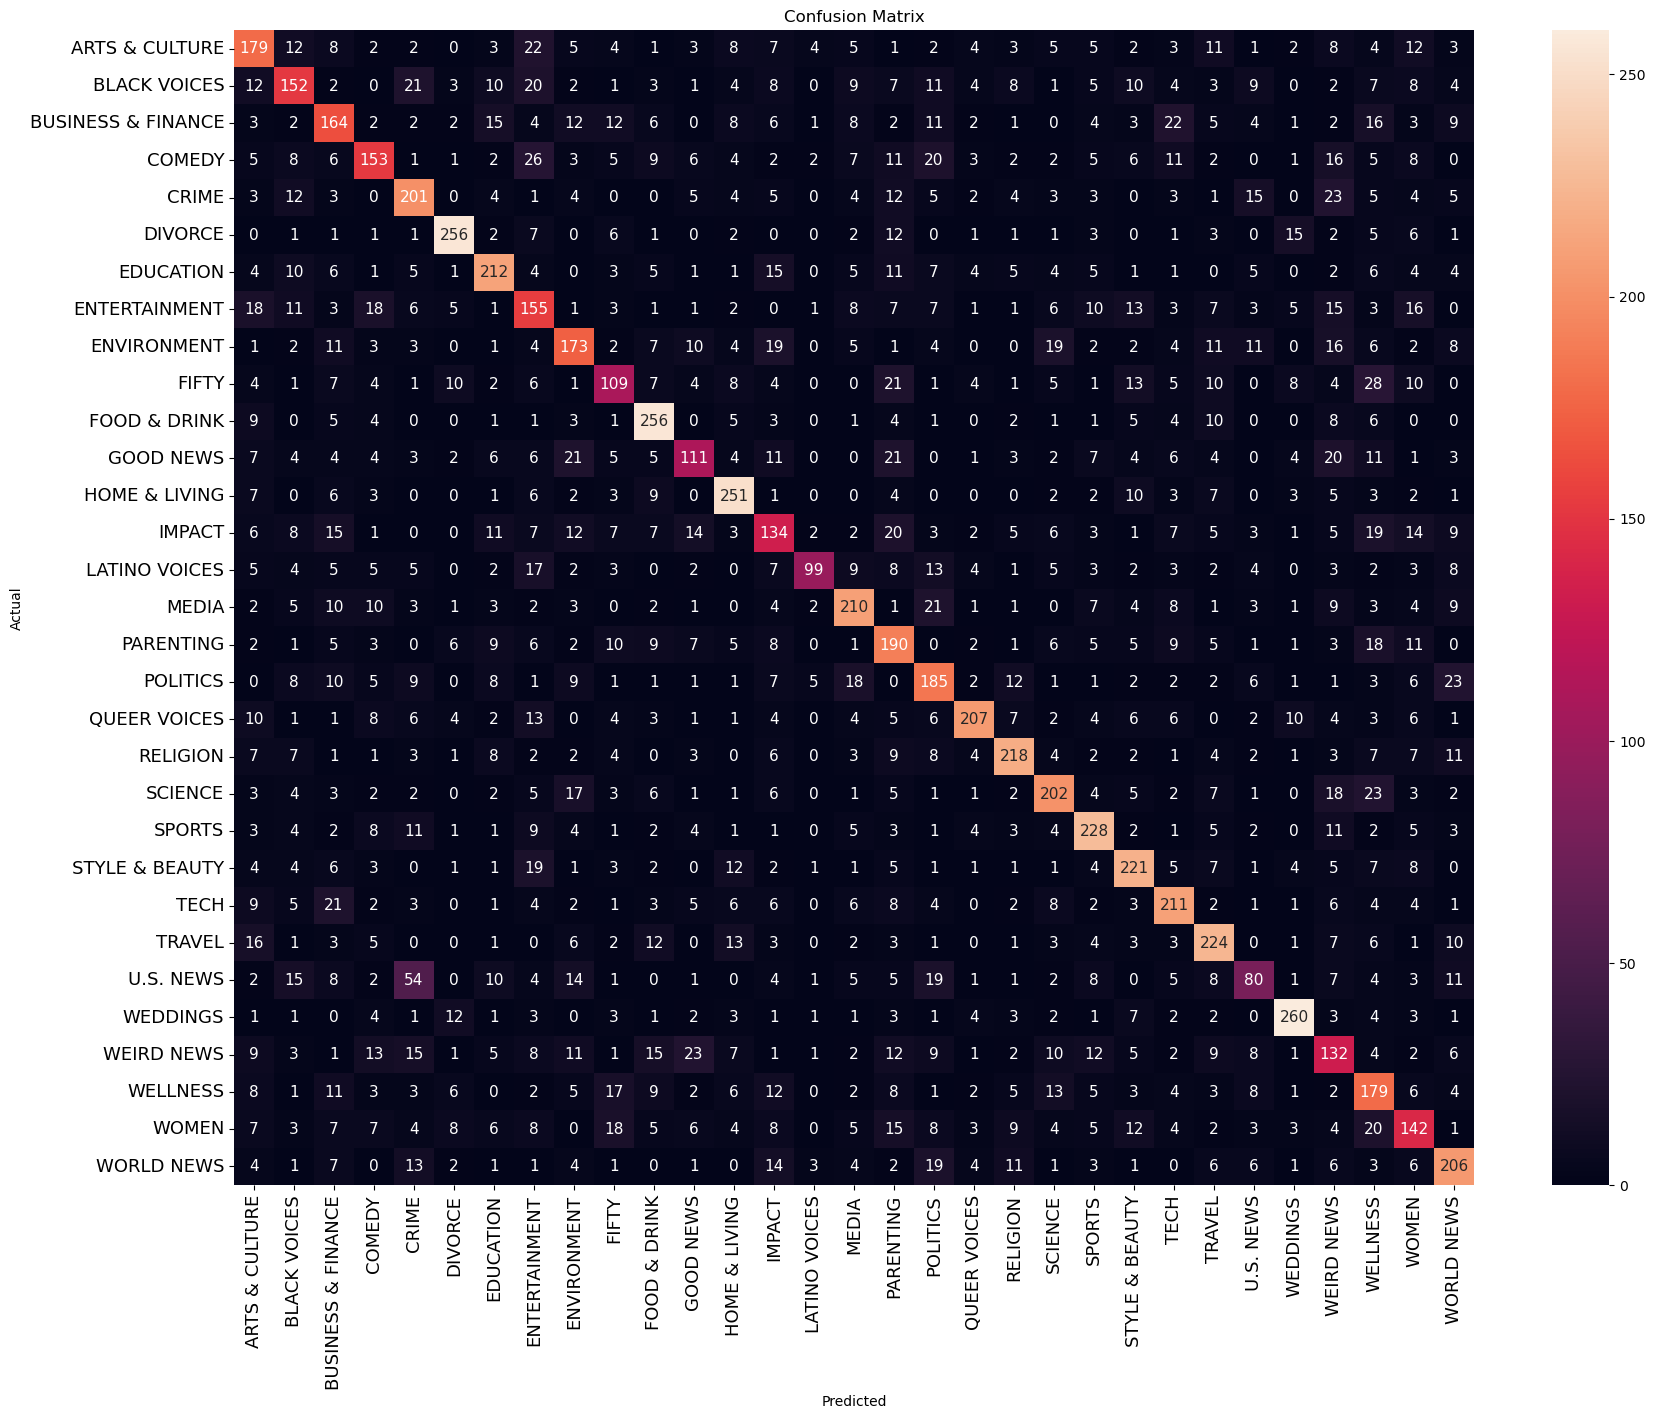

In [82]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


**Summary of the Logistic Regression Model**

The results were encouraging for the Naive-Bayes model, however for the Logistc Regressor, the results were not favourable. The overall accuracy fell from 66.76% down to 56.98%. This is large degradation of almost 10%.

Precision has fallen from 0.63 to 0.57, however there has been a slight improvement in recall from 0.50 to 0.57. The F1-score has also improved from 0.54 to 0.57.

### Conclusion of Undersampling  

It is interesting to see how the results were so different for the two baseline models. The logistic regression model clearly had the best results in the baseline and also for the reduced number of categories (refer to the main notebook). As its best performance was better, I have decided to not include undersampling before evaluating the neural network models.  

It can be concluded that there were improvements in predicting the minority classes, but this has drastically affected the overall accuracy. Clearly, the larger amount of training data is very beneficial to a dataset like this where there is a large number of additional words and variability for the models to learn from. As there are no critical categories and accurately classifying any particular category is no more important than any other, it can be concluded that utilising the full dataset is clearly more advantageous to build an overall more accurate model than having a fairly balanced dataset. SMOTE is a viable option worthy of exploration, but due to the much larger processing times required, it is not an option that can be explored.

**This project will not implement undersampling!**